<a href="https://colab.research.google.com/github/shishir-py/ml-projects/blob/main/automl_gbm_uptuna_feature_imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e15/sample_submission.csv
/kaggle/input/playground-series-s3e15/data.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Loding Data

In [ ]:
data_path="/kaggle/input/playground-series-s3e15/data.csv"
sub_path="/kaggle/input/playground-series-s3e15/sample_submission.csv"

In [ ]:
df=pd.read_csv(data_path)

In [ ]:
df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


# Data info
## Here's a brief explanation of each column:

  Index: This column represents a unique identifier for each observation in the table.

  Id: This column may represent an additional identifier for each observation. It's not clear from the limited information provided what this column refers to specifically.

  Author: This column may represent the name of the researcher or research team who conducted the experiment or collected the data.

  Geometry: This column represents the type of geometry used in the experiment, such as a tube or annulus.

  Pressure [MPa]: This column represents the pressure of the fluid in the experiment, measured in megapascals.

  Mass_flux [kg/m2-s]: This column represents the mass flux of the fluid in the experiment, measured in kilograms per square meter per second.

  X_e_out [-]: This column represents a variable related to the exit quality of the fluid in the experiment. It's not clear from the limited information provided what this variable specifically refers to.

  D_e [mm]: This column represents the equivalent diameter of the experimental geometry, measured in millimeters.

  D_h [mm]: This column represents the hydraulic diameter of the experimental geometry, measured in millimeters.

  Length [mm]: This column represents the length of the experimental geometry, measured in millimeters.

  Chf_exp [MW/m2]: This column represents the experimental critical heat flux, measured in megawatts per square meter.

# Examine the dataset for any missing values and understand the distribution of the features in the dataset

In [ ]:
!pip install dabl


Target looks like regression


[<AxesSubplot: title={'center': 'Target distribution'}, xlabel='x_e_out [-]', ylabel='frequency'>,
 array([[<AxesSubplot: title={'center': 'F=-4.81E-01'}, xlabel='chf_exp [MW/m2]', ylabel='x_e_out [-]'>,
         <AxesSubplot: title={'center': 'F=3.04E-01'}, xlabel='length [mm]'>,
         <AxesSubplot: title={'center': 'F=2.64E-01'}, xlabel='D_h [mm]'>],
        [<AxesSubplot: title={'center': 'F=1.63E-01'}, xlabel='D_e [mm]', ylabel='x_e_out [-]'>,
         <AxesSubplot: title={'center': 'F=-1.59E-01'}, xlabel='pressure [MPa]'>,
         <AxesSubplot: title={'center': 'F=-1.58E-01'}, xlabel='mass_flux [kg/m2-s]'>]],
       dtype=object),
 array([[<AxesSubplot: title={'center': 'F=4.10E-01'}, xlabel='x_e_out [-]', ylabel='author'>,
         <AxesSubplot: title={'center': 'F=1.83E-01'}, xlabel='x_e_out [-]', ylabel='geometry'>]],
       dtype=object)]

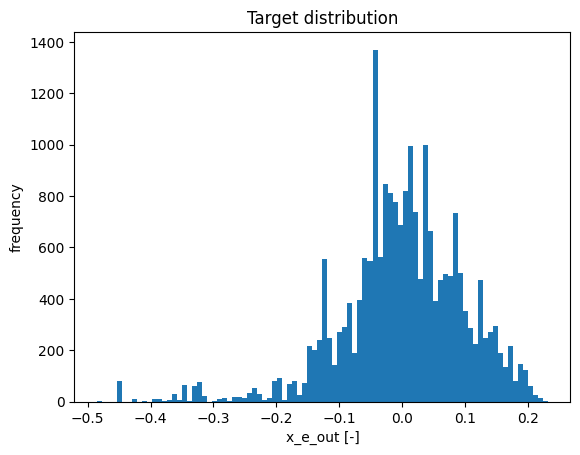

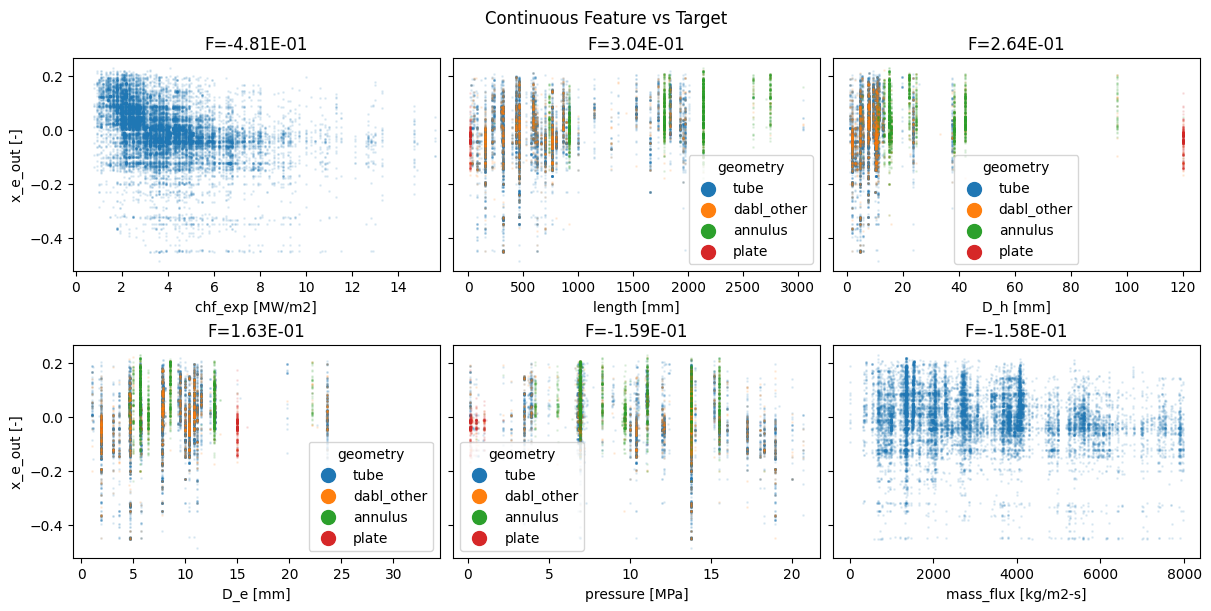

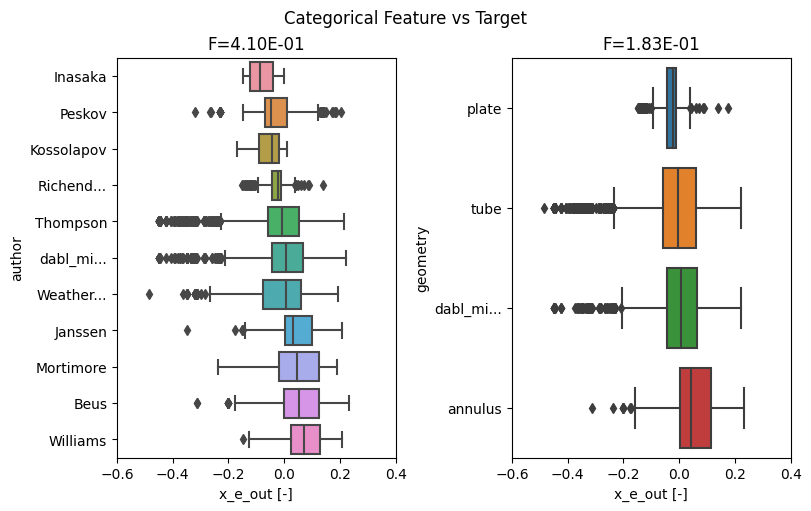

In [ ]:
import dabl
dabl.plot(df,target_col='x_e_out [-]')

In [ ]:
df.columns

Index(['id', 'author', 'geometry', 'pressure [MPa]', 'mass_flux [kg/m2-s]',
       'x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]',
       'chf_exp [MW/m2]'],
      dtype='object')

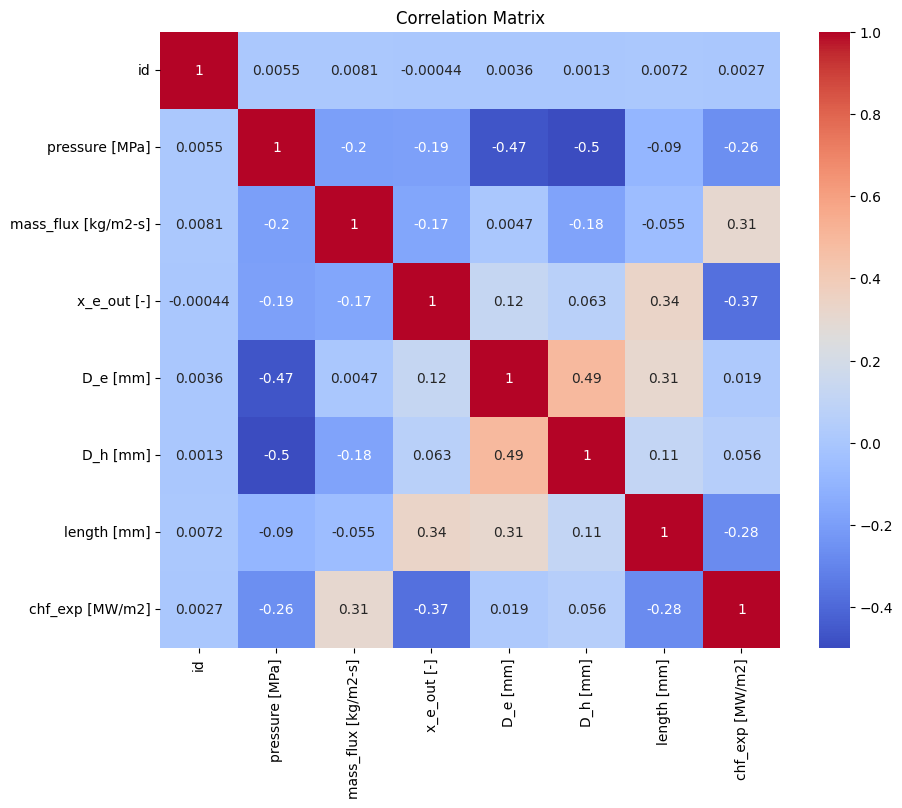

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Examine the dataset for missing values
print(df.isnull().sum())



id                         0
author                  5024
geometry                5500
pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm]                4589
length [mm]             4759
chf_exp [MW/m2]            0
dtype: int64


In [ ]:
# Get the summary statistics of the dataset
print(df.describe())

# Get the frequency distribution of categorical variables
print(df['author'].value_counts())


                 id  pressure [MPa]  mass_flux [kg/m2-s]   x_e_out [-]  \
count  31644.000000    27192.000000         26853.000000  21229.000000   
mean   15821.500000       10.640747          3068.011023     -0.000453   
std     9134.980296        4.333683          1777.032080      0.100911   
min        0.000000        0.100000             0.000000     -0.866700   
25%     7910.750000        6.890000          1519.000000     -0.046600   
50%    15821.500000       11.070000          2731.000000      0.003800   
75%    23732.250000       13.790000          4069.000000      0.064800   
max    31643.000000       20.680000          7975.000000      0.232000   

           D_e [mm]      D_h [mm]   length [mm]  chf_exp [MW/m2]  
count  26156.000000  27055.000000  26885.000000     31644.000000  
mean       8.629255     14.174330    832.987391         3.796985  
std        5.185692     19.838489    672.299239         1.983991  
min        1.000000      1.000000     10.000000         0.800000 

In [ ]:
# Group the data by author and geometry, and count the occurrences
grouped = df.groupby(['author', 'geometry']).size().reset_index(name='count')

# Display the results
print(grouped)
print(df['author'].unique())

          author geometry  count
0           Beus  annulus   1308
1           Beus     tube     29
2        Inasaka    plate      1
3        Inasaka     tube     34
4        Janssen  annulus   2247
5        Janssen    plate      1
6        Janssen     tube     31
7     Kossolapov  annulus      1
8     Kossolapov    plate     82
9     Kossolapov     tube      3
10     Mortimore  annulus    152
11     Mortimore    plate      2
12     Mortimore     tube      6
13        Peskov  annulus      1
14        Peskov    plate      3
15        Peskov     tube    872
16  Richenderfer  annulus      6
17  Richenderfer    plate    408
18  Richenderfer     tube     35
19      Thompson  annulus      9
20      Thompson    plate     11
21      Thompson     tube  14324
22   Weatherhead  annulus      1
23   Weatherhead     tube   1698
24      Williams  annulus      1
25      Williams    plate      1
26      Williams     tube    719
['Thompson' 'Beus' nan 'Peskov' 'Janssen' 'Weatherhead' 'Inasaka'
 'Williams

In [ ]:
# Print the rows where both "author" and "geometry" are NaN
print(len(df[(df["author"].isnull()) & (df["geometry"].isnull())]))

866


In [ ]:
data=df.copy()
# only rows where both author and geometry are NaN values will be dropped
# data.dropna(subset=['author', 'geometry'], how='all', inplace=True)
#now replacing the rest nan values with 'unknown'
data[['author', 'geometry']] = df[['author', 'geometry']].fillna('Unknown')



In [ ]:
# This will fill the missing values in "pressure" and max flux  column with the mean of the respective "geometry" group
data['pressure [MPa]'] = data.groupby('geometry')['pressure [MPa]'].apply(lambda x: x.fillna(x.mean()))
data['mass_flux [kg/m2-s]'] = data.groupby('geometry')['mass_flux [kg/m2-s]'].apply(lambda x: x.fillna(x.mean()))
data['D_e [mm]'] = data.groupby('geometry')['D_e [mm]'].apply(lambda x: x.fillna(x.mean()))
data['D_h [mm]'] = data.groupby('geometry')['D_h [mm]'].apply(lambda x: x.fillna(x.mean()))
data['length [mm]'] = data.groupby('geometry')['length [mm]'].apply(lambda x: x.fillna(x.mean()))





In [ ]:
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
print("\nMissing Values Percentage:\n", missing_percentage)
# missing_values


Missing Values Percentage:
 id                      0.000000
author                  0.000000
geometry                0.000000
pressure [MPa]          0.000000
mass_flux [kg/m2-s]     0.000000
x_e_out [-]            32.913032
D_e [mm]                0.000000
D_h [mm]                0.000000
length [mm]             0.000000
chf_exp [MW/m2]         0.000000
dtype: float64


x_e_out has a negative correlation with pressure and mass_flux, and a positive correlation with length. D_e and D_h have a moderate positive correlation with each other and length has a moderate positive correlation with x_e_out. chf_exp has a moderate negative correlation with x_e_out.

In [ ]:
data.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.000000,3770.0,0.1754,8.406165,10.8,432.0,3.6
1,1,Thompson,tube,11.163435,6049.0,-0.0416,10.300000,10.3,762.0,6.2
2,2,Thompson,Unknown,13.790000,2034.0,0.0335,7.700000,7.7,457.0,2.5
3,3,Beus,annulus,13.790000,3679.0,-0.0279,5.600000,15.2,2134.0,3.0
4,4,Unknown,tube,13.790000,686.0,NaN,11.100000,11.1,457.0,2.8


# splitting the data in two set

In [ ]:
# Split the data into two sets based on the presence of missing values in the target column
df_missing = data[data['x_e_out [-]'].isnull()]
df_non_missing = data[~data['x_e_out [-]'].isnull()]


In [ ]:
df_missing.shape

(10415, 10)

In [ ]:
df_test=df_missing.drop('x_e_out [-]', axis=1)
df_train=df_non_missing.drop('id', axis=1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Define the categorical columns to be encoded
cat_cols = ['author', 'geometry']

# Instantiate the encoder
encoder = OneHotEncoder()

# Fit and transform the training set
train_encoded = encoder.fit_transform(df_train[cat_cols])

# Transform the test set
test_encoded = encoder.transform(df_test[cat_cols])

# Get the encoded column names
encoded_cols = encoder.get_feature_names_out(cat_cols)

# Create new dataframes with the encoded columns
X_train_encoded_df = pd.DataFrame(train_encoded.toarray(), columns=encoded_cols)
X_test_encoded_df = pd.DataFrame(test_encoded.toarray(), columns=encoded_cols)
#resetting the index
df_train.reset_index(drop=True, inplace=True)
X_train_encoded_df.reset_index(drop=True, inplace=True)
df_encoded_train = pd.concat([df_train.drop(cat_cols, axis=1), X_train_encoded_df], axis=1)

df_test.reset_index(drop=True, inplace=True)
X_test_encoded_df.reset_index(drop=True, inplace=True)
df_encoded_test = pd.concat([df_test.drop(cat_cols, axis=1), X_test_encoded_df], axis=1)


In [ ]:
df_encoded_train.columns

Index(['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]', 'D_e [mm]',
       'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]', 'author_Beus',
       'author_Inasaka', 'author_Janssen', 'author_Kossolapov',
       'author_Mortimore', 'author_Peskov', 'author_Richenderfer',
       'author_Thompson', 'author_Unknown', 'author_Weatherhead',
       'author_Williams', 'geometry_Unknown', 'geometry_annulus',
       'geometry_plate', 'geometry_tube'],
      dtype='object')

# Modeling the data:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the dataset into features and target
X= df_train.drop(columns=['x_e_out [-]'])
y= df_train['x_e_out [-]']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(16983, 8)
(4246, 8)
(16983,)
(4246,)


In [ ]:
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import optuna
from h2o.estimators import H2OGradientBoostingEstimator
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
data = df_encoded_train

# Split the dataset into features and target
X = data.drop(columns=['x_e_out [-]'])
y = data['x_e_out [-]']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the column transformer to handle missing values in different columns
column_transformer = ColumnTransformer(
    transformers=[
        ('pressure', 'mean', ['pressure [MPa]']),
        ('mass_flux', 'mean', ['mass_flux [kg/m2-s]']),
        ('D_e', 'mean', ['D_e [mm]']),
        ('D_h', 'mean', ['D_h [mm]']),
        ('length', 'mean', ['length [mm]'])
    ])

# Define the pipeline with the column transformer and the estimator
pipeline = Pipeline([
    ('column_transformer', column_transformer),
    ('estimator', H2OGradientBoostingEstimator())
])

# Initialize H2O
h2o.init()

# Convert the Pandas dataframes to H2O frames
h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
h2o_test = h2o.H2OFrame(X_test)

# Define the search space for Optuna
def objective(trial):
    # Define the hyperparameters to search over
    hyperparameters = {
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_rows': trial.suggest_int('min_rows', 1, 10),
        'sample_rate': trial.suggest_uniform('sample_rate', 0.5, 1.0)
    }
    
    # Train a GBM model with the current hyperparameters
    model = H2OGradientBoostingEstimator(**hyperparameters)
    model.train(x=list(X_train.columns), y='x_e_out [-]', training_frame=h2o_train)
    
    # Generate predictions on the test set
    y_pred = model.predict(h2o_test).as_data_frame()['predict'].values
    
    # Compute the RMSE between the predictions and the true values
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

# Run Optuna to optimize the hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Train an AutoML model with H2O
aml = H2OAutoML(max_models=10, seed=1, exclude_algos=["DeepLearning"])
aml.train(x=list(X_train.columns), y='x_e_out [-]', training_frame=h2o_train)

# Get the best AutoML model
best_model = aml.leader

# Generate predictions on the test set using the best AutoML model
y_pred_automl = best_model.predict(h2o_test).as_data_frame()['predict'].values

# Generate predictions on the test set using the best Optuna-tuned GBM model
best_params = study.best_params
best_gbm = H2OGradientBoostingEstimator(**best_params)
best_gbm.train(x=list(X_train.columns), y='x_e_out [-]', training_frame=h2o_train)



h2o:1: DeprecationWarning: Your Python version is 3.10.10. The support for this version will be removed in H2O 3.42.0.1.


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpovyhu0ge
  JVM stdout: /tmp/tmpovyhu0ge/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpovyhu0ge/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_unknownUser_i6jq37
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |

[I 2023-05-17 03:00:31,704] A new study created in memory with name: no-name-e42c5edd-fa5a-4d1b-8ce5-f59b38a6dce8


████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:00:38,237] Trial 0 finished with value: 0.0771802719884798 and parameters: {'max_depth': 13, 'min_rows': 10, 'sample_rate': 0.7467046845474761}. Best is trial 0 with value: 0.0771802719884798.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:00:42,586] Trial 1 finished with value: 0.07588530073100436 and parameters: {'max_depth': 10, 'min_rows': 8, 'sample_rate': 0.8623641507342305}. Best is trial 1 with value: 0.07588530073100436.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:00:48,416] Trial 2 finished with value: 0.08085400044382379 and parameters: {'max_depth': 14, 'min_rows': 3, 'sample_rate': 0.9426906840715237}. Best is trial 1 with value: 0.07588530073100436.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:00:51,408] Trial 3 finished with value: 0.07576372626703473 and parameters: {'max_depth': 10, 'min_rows': 10, 'sample_rate': 0.9209238672908859}. Best is trial 3 with value: 0.07576372626703473.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:00:55,569] Trial 4 finished with value: 0.07846332393830611 and parameters: {'max_depth': 17, 'min_rows': 9, 'sample_rate': 0.7232400562488674}. Best is trial 3 with value: 0.07576372626703473.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:00:59,093] Trial 5 finished with value: 0.07757396687608208 and parameters: {'max_depth': 14, 'min_rows': 9, 'sample_rate': 0.941981819920835}. Best is trial 3 with value: 0.07576372626703473.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:01:03,901] Trial 6 finished with value: 0.0813733303985277 and parameters: {'max_depth': 14, 'min_rows': 2, 'sample_rate': 0.8830285578528985}. Best is trial 3 with value: 0.07576372626703473.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:01:05,706] Trial 7 finished with value: 0.07555284784987991 and parameters: {'max_depth': 5, 'min_rows': 2, 'sample_rate': 0.9949674919417424}. Best is trial 7 with value: 0.07555284784987991.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:01:09,886] Trial 8 finished with value: 0.0802297674723457 and parameters: {'max_depth': 13, 'min_rows': 2, 'sample_rate': 0.7207403517267874}. Best is trial 7 with value: 0.07555284784987991.


███████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

[I 2023-05-17 03:01:14,790] Trial 9 finished with value: 0.08135962736895871 and parameters: {'max_depth': 15, 'min_rows': 3, 'sample_rate': 0.8823461879446222}. Best is trial 7 with value: 0.07555284784987991.


███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1684292422075_23


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          21764                  5            5            5             16            32            29.96

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.00519068971042544
RMSE: 0.07204644134463159
MAE: 0.050257197743128076
RMSLE: 0.08673069405024378
Mean Residual Deviance: 0.00519068971042544

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae          training_deviance
---  -------------------  ----------  -----------------  -------------------  --------------------  ---------------------
     2023-05-17 03:03:35  0.084 sec   0.0                0.10093488639535168  0.07409460318343265   0.01018785129164255
     2023-05-17 03:03:35  0.133 sec   1.0                0.09731187185161352  0.07042203392433329   0.009469600403264852
     2023-05-17 03:03:35  0.163 sec   2.0                0.09427781659774982  0.06735572980386066   0.008888306702438951
     2023-05-17 03:03:35  0.202 sec   3.0                0.09173315952071628  0.06482349445687251   0.008414972555653181
     2023-05-17 03:03:35  0.239 sec   4.0                0.08955669004168806  0.06277008403236382   0.00802040073122299
     2023-05-17 03:03:36  0.270 sec   5.0                0.0875588157559352   0.0610091320169222    0.007666546216581807
     2023-05-17 03:03:36  0.302 sec   6.0                0.08585901191982505  0.059595469386098415  0.00737176992784866
     2023-05-17 03:03:36  0.333 sec   7.0                0.08449145484444037  0.058404030919391656  0.007138805941730106
     2023-05-17 03:03:36  0.367 sec   8.0                0.08324118516230662  0.05747546654755115   0.006929094907225416
     2023-05-17 03:03:36  0.397 sec   9.0                0.08222386484411945  0.05666386748710766   0.006760763949904022
---  ---                  ---         ---                ---                  ---                   ---
     2023-05-17 03:03:37  1.460 sec   41.0               0.07270112371264649  0.05062520320861397   0.005285453389081529
     2023-05-17 03:03:37  1.495 sec   42.0               0.07262963638326682  0.050579268745784875  0.0052750640811655555
     2023-05-17 03:03:37  1.531 sec   43.0               0.07254773197799338  0.050527905787533765  0.005263173415150764
     2023-05-17 03:03:37  1.570 sec   44.0               0.07246451310882597  0.05047721607021479   0.005251105660099211
     2023-05-17 03:03:37  1.605 sec   45.0               0.07237414820964728  0.0504566721794208    0.00523801732907199
     2023-05-17 03:03:37  1.638 sec   46.0               0.07231500623420159  0.05041202219236046   0.0052294601266526155
     2023-05-17 03:03:37  1.669 sec   47.0               0.07225714565580452  0.050367015060831515  0.00522109509832415
     2023-05-17 03:03:37  1.698 sec   48.0               0.07214643621384395  0.05031360856098865   0.005205108258358254
     2023-05-17 03:03:37  1.731 sec   49.0               0.07212004184494253  0.05028507891003835   0.005201300435716261
     2023-05-17 03:03:37  1.762 sec   50.0               0.07204644134463159  0.050257197743128076  0.00519068971042544
[51 rows x 7 columns]


Variable Importances: 
variable             relative_importance    scaled_importance       percentage
-------------------  ---------------------  ----------------------  ----------------------
chf_exp [MW/m2]      193.7314453125         1.0                     0.4346088918768546
pressure [MPa]       102.27083587646484     0.5279000304338621      0.22943004724861862
D_e [mm]       

In [ ]:
# Calculate the mean squared error for the GBM model
y_pred_gbm = best_gbm.predict(h2o_test).as_data_frame()['predict'].values

mse_gbm = mean_squared_error(y_test, y_pred_gbm)
print(f"MSE for the GBM model: {mse_gbm:.4f}")

# Generate predictions on the test set using the best AutoML model
y_pred_automl = best_model.predict(h2o_test).as_data_frame()['predict'].values

# Calculate the mean squared error for the AutoML model
mse_automl = mean_squared_error(y_test, y_pred_automl)
print(f"MSE for the AutoML model: {mse_automl:.4f}")

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
MSE for the GBM model: 0.0057
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
MSE for the AutoML model: 0.0055


In [ ]:
df_encoded_test
h2o_test_df = h2o.H2OFrame(df_encoded_test)
y_pred_automl = best_model.predict(h2o_test_df).as_data_frame()['predict'].values



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
len(y_pred_automl)

10415

In [ ]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    "id": df_encoded_test["id"],
    "x_e_out [-]": y_pred_automl
})

# Save submission file to CSV format
submission_df.to_csv("submission.csv", index=False)

In [ ]:
pd.read_csv('submission.csv')

,id,x_e_out [-]
0,4,0.007673
1,7,-0.099846
2,10,-0.051673
3,12,0.006737
4,23,0.050615
...,...,...
10410,31633,0.064242
10411,31634,-0.046969
10412,31637,0.044858
10413,31640,-0.064193
